# **Image denoising using Noise2Void (Notebook dedicated for xyz stacks) **

---

This notebook contains the code to run the version of Noise2Void which allow to denoise xyz images (stack of images). In this notebook, you can train your own network to denoise images. The notebook and original code is based on following article:

**Noise2Void - Learning Denoising from Single Noisy Images**
Alexander Krull, Tim-Oliver Buchholz, Florian Jug
https://arxiv.org/abs/1811.10980

Original notebook of Noise2Void:
https://github.com/juglab/n2v


This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories. 

**Please also cite this original paper when using or developing this notebook.** 


# **How to use this notebook?**
---
On the left side you see **Table of contents, Code snippets** and **Files**.

**Table of contents** = contains this table of contents of this notebook. Click the content to move quickly.

**Code snippets** = contain examples how to code certain tasks. You do not need this section to use this notebook.

**Files** = contains all available files. You can **upload** here your files and **connect your Google Drive** (see section 2.3). Remember that all uploaded files will be gone after changing the runtime (see section 2.1) or you exit this notebook. All files saved in Google Drive will remain. Do not use Mount Drive-button; your Google Drive is connected in section 2.3.


"sample data" is default file. Do not upload anything here! 

---
This notebook contain **cells** which can contain ether text or code. 

**Text cell** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Coding cell** contains code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

**If you make any changes to coding cell**, please make a new copy of the notebook into your Google Drive. Right click the gray area below the play button and choose FORM -> SHOW CODE. The code is revealed and can be hided again the same way.

Also, it is advisable to use `#`-mark in cell. Mark allows you to keep the original code piece in cell.
For example:

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

---

#**0. Before getting started**
---
1. Create a following folder tree in your Google Drive:

*   Data
    - test
    - train
      - training_images
      - trained_model
    - results

4. Place all your test images in the **test** folder
3. Place all your training images in the **images** folder.
5. **Trained_model** folder will contain files of parameters of trained network.
7. **Results** - folder will contain denoised images and training values as csv file. Your original images remain in test-folder and unmodified.
---


# **1. Set the Runtime type and mount your Google Drive**

### **1.1. Set the Runtime type**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU) is accelarates the processing of graphic images. Without GPU the processing would take longer time)*

---



### **1.2. Mount your Google Drive**

In [0]:
#@markdown Play the cell to Mount your Google Drive

#@markdown * Click the appearing URL. 

#@markdown * Select or sign in your Google Account. 

#@markdown * Copy the appearing authorization code. 

#@markdown * Enter your authorization.

#@markdown * Click "Files" site on the left. Refresh the site. Your Drive should be shown here now as "drive". 

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#**2. Install Network and Dependencies**

### **2.1. Enable Tensorflow 1**

Tensorflow is open-source library, which enables the use of deep-learning programs. 

**What you need to do:** Move your cursor on the `[ ]` mark below. A play-button appear. Click button to start. When operation is ready the animation of play button stops.



In [0]:
#@markdown Play the cell to enable Tensorflow 1.

#@markdown The cell wil print the current version of T1.
# Enable the Tensorflow 1 instead of the Tensorflow 2.
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

print("Tensorflow enabled.")

1.15.0
Tensorflow enabled.


### **2.2 Setup of the notebook**

### **2.3. Install Noise2Void 3D**

Here we install Noise2Void. 

In [0]:
#@markdown Play the cell to install Noise2Void 3D.

# Instal Noise2Void
!pip install n2v

print("Noise2Void installed.")

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 133kB 10.7MB/s 
     |████████████████████████████████| 18.1MB 251kB/s 
Noise2Void installed.


In [0]:
#@markdown Play the cell to install the libraries

# We import libaries.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
import pandas as pd
import csv

!pip install memory_profiler
%load_ext memory_profiler

print("Libraries installed")

Using TensorFlow backend.


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=97a2a32971c331a494a0c262a8c96c4bc4a246282872cb24fb4ff6e4ec3f562a
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
Libraries installed


# **3. Select your parameters and paths**

**What to do:** Enter the following paths and parameters. Copy (right-click) the reguired path from the left from "Files" to form right side of the cell. (looks like: /content/gdrive/Experiment_A1/train/images). **Finally, play the cell to load information to the Noise2Void**. 

 **`prediction`:** The path for your images to-be predicted.

**`results`:** The path for your results.

**`training`:** The path of the folder containing your training images. These images remain unmodified and N2V only study them. Use only tif-files!

**`name`:** The name of you model. Use only my_model1 -style, not my-model1.  If you already have trained networks, enter the name of the pretrained model (the name of the folder which is in trained_model -folder, includes all files of pretrained networks)

**`modelpath`:** The path of the folder containing your model to-be-trained or pretrained model. All pretrained and will-be trained models are here (see Section 1). If you already have pretrained networks, enter the path of the pretrained model (the name of the folder in which the my_model is).

**`steps`:** The number of steps in each epoch. Original N2V network is trained with few dozen steps. If you already have trained networks, leave this untouched (N2V uses pretrained model).

**`epochs`:** The number of epochs (rounds) network will be trained. Original N2V network is trained wth 100 epochs. If you already have trained networks, leave this untouched (N2V uses pretrained model).

**`heigth`:** The the height of the batch. Heigth must be smaller than Z-direction and divisible to 4. For example, image (Z = 5) height can be 4. 

**If you are unsure the shape of your image**, play this cell to print the value. For example, for the image `(1, 5, 1024, 1024, 1)` the length of the Z-axel is 5. Input the height and play the cell again (parameters and paths are updated every time when the cell is executed).

**`Size`:** The the width of the batch (64 is good default size).




In [0]:

# Create DataGenerator-object.
datagen = N2V_DataGenerator()

# paths to prediction and results folders
#@markdown ##Path to predicted images and results:
prediction = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction" #@param {type:"string"}
test_data = prediction 
results = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/results" #@param {type:"string"}

#@markdown ##Training the network:

#@markdown Path to training images:
training = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/train" #@param {type:"string"}
training_images = training
imgs = datagen.load_imgs_from_directory(directory = training_images, dims='ZYX')

#@markdown Name of the model and path to model folder:
name = "N2V3D-thesis" #@param {type:"string"}
my_model = name
modelpath = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/results" #@param {type:"string"}
path_model = modelpath

#@markdown Number of steps and epochs:
steps =  50#@param {type:"number"}
epochs = 100 #@param {type:"number"}

#@markdown Patch size (pixels).  Use only number divisible by 4:
number =  400#@param {type:"number"}
size =  32#@param {type:"number"}
width = size
height = 4 #@param {type:"number"}

print("Parameters initated.")

Parameters initated.


#**4. Train your network**

### **4.1 Preview of training image**

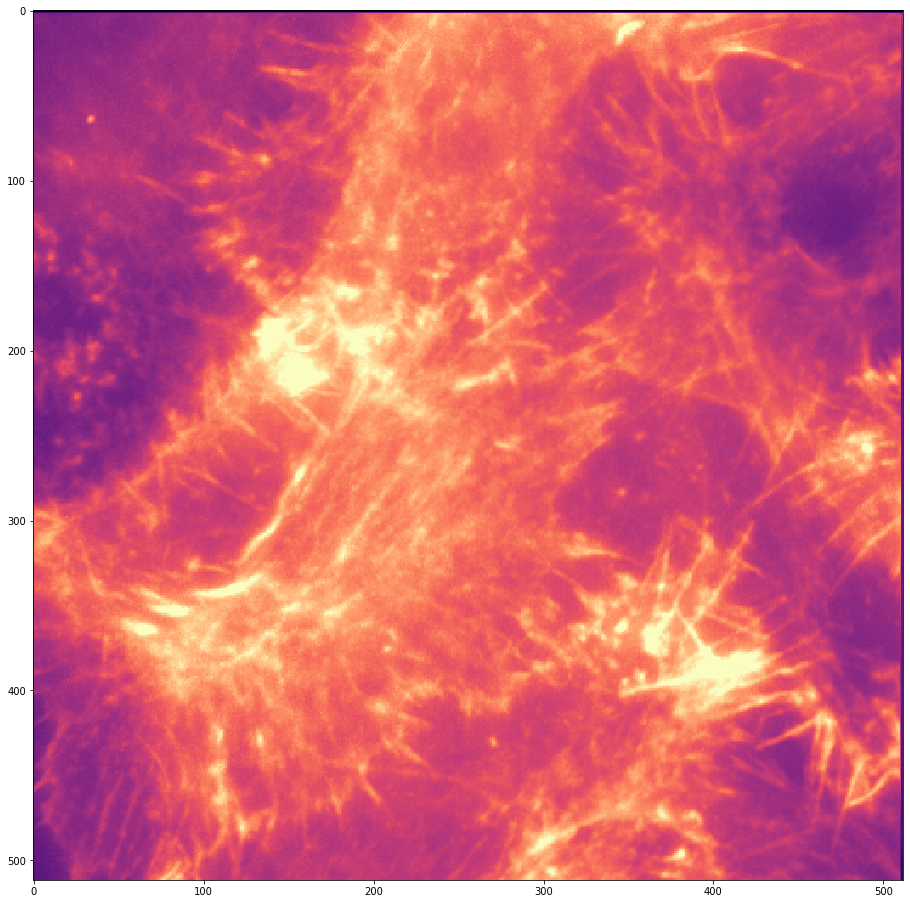

In [0]:
#@markdown Play the cell to look maximum projection of the volume.

# create the plot to look maximum projection of the volume.
# the code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

### **4.2 Extract training image into patches**

Generated patches: (3200, 4, 32, 32, 1)
3200 patches created.
3000 patch images for training.
200 patch images for validation (6.25 %).
peak memory: 569.47 MiB, increment: 0.01 MiB


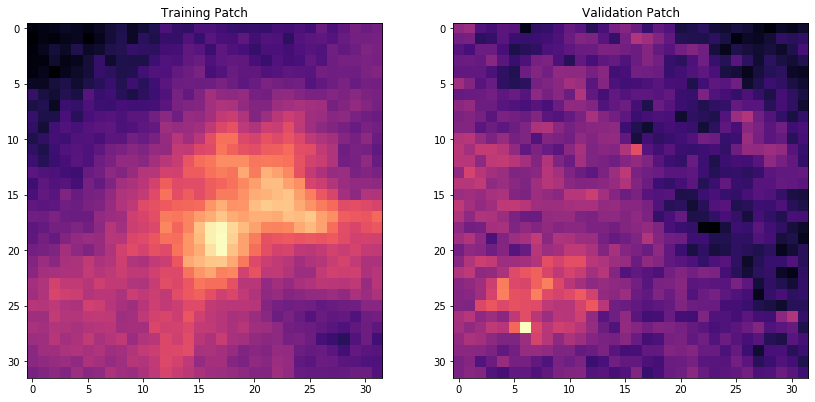

In [0]:
#@markdown Play the cell to generate patches. Batches  quicken network training. The cell will print the preview of some batches.

# Create batches from the training data.
# The code is inspired from the original notebook (https://github.com/juglab/n2v)
patches = datagen.generate_patches_from_list(imgs[:1], num_patches_per_img=number,shape=(height, width, width))

# Patches are divited into training and validation patch set. This inhibits over-lapping of patches. 
number_train_images =len(patches)-int(len(patches)*0.0625)
X = patches[:number_train_images]
X_val = patches[number_train_images:]

print(len(patches),"patches created.")
print(number_train_images,"patch images for training.")
print((len(patches)-number_train_images),"patch images for validation (6.25 %).")
%memit 

# Shows a training batch and a validation batch.
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,1,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,2,...,0],cmap='magma')
plt.title('Validation Patch');

### **4.3 Setup the model**

In [0]:
#@markdown Play the cell to input parameters into the model.

# creates Congfig object. 
# The code is from the original notebook (https://github.com/juglab/n2v)
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=steps,train_epochs=epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=number, n2v_perc_pix=1.6, n2v_patch_shape=(height, size, size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

vars(config)

# a name used to identify the model. Change the name of the variable.
model_name = my_model

# the base directory in which our model will live
basedir = path_model

# Create the default model.
model = N2V(config=config, name=model_name, basedir=basedir)
print("Parameters transferred into the model.")

/usr/local/lib/python3.6/dist-packages/n2v/models/n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: /content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/results/N2V3D-thesis
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))






Parameters transferred into the model.


### **4.4 Train the model**

In this section we start the training of network.

You see results for every epoch (round). You can estimate the training time by following equation: t(training) = ( t(s)/epoch x epochs)/60. For example: 

t(training) = (16 s/epoch x 400 epochs)/60 = 106,7 min

**CRITICAL NOTE: Google Colab has time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours!** If training takes longer than 12 hours, please decrease the training parameters or training data.

In [0]:
#@markdown Play the cell to start training
%memit
# the training starts.
# The code is from the original notebook (https://github.com/juglab/n2v)
history = model.train(X, X_val)
%memit
print("Training the network, done.")

peak memory: 579.86 MiB, increment: 0.00 MiB



Preparing validation data:   0%|          | 0/200 [00:00<?, ?it/s]

65 blind-spots will be generated per training patch of size (4, 32, 32).


Preparing validation data: 100%|██████████| 200/200 [00:00<00:00, 1308.96it/s]










The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/100
 4/50 [=>............................] - ETA: 52:00 - loss: 1.5174 - n2v_mse: 1.5174 - n2v_abs: 0.9080

###**4.5 Estimate the training**


100%|██████████| 32/32 [00:09<00:00,  5.17it/s]


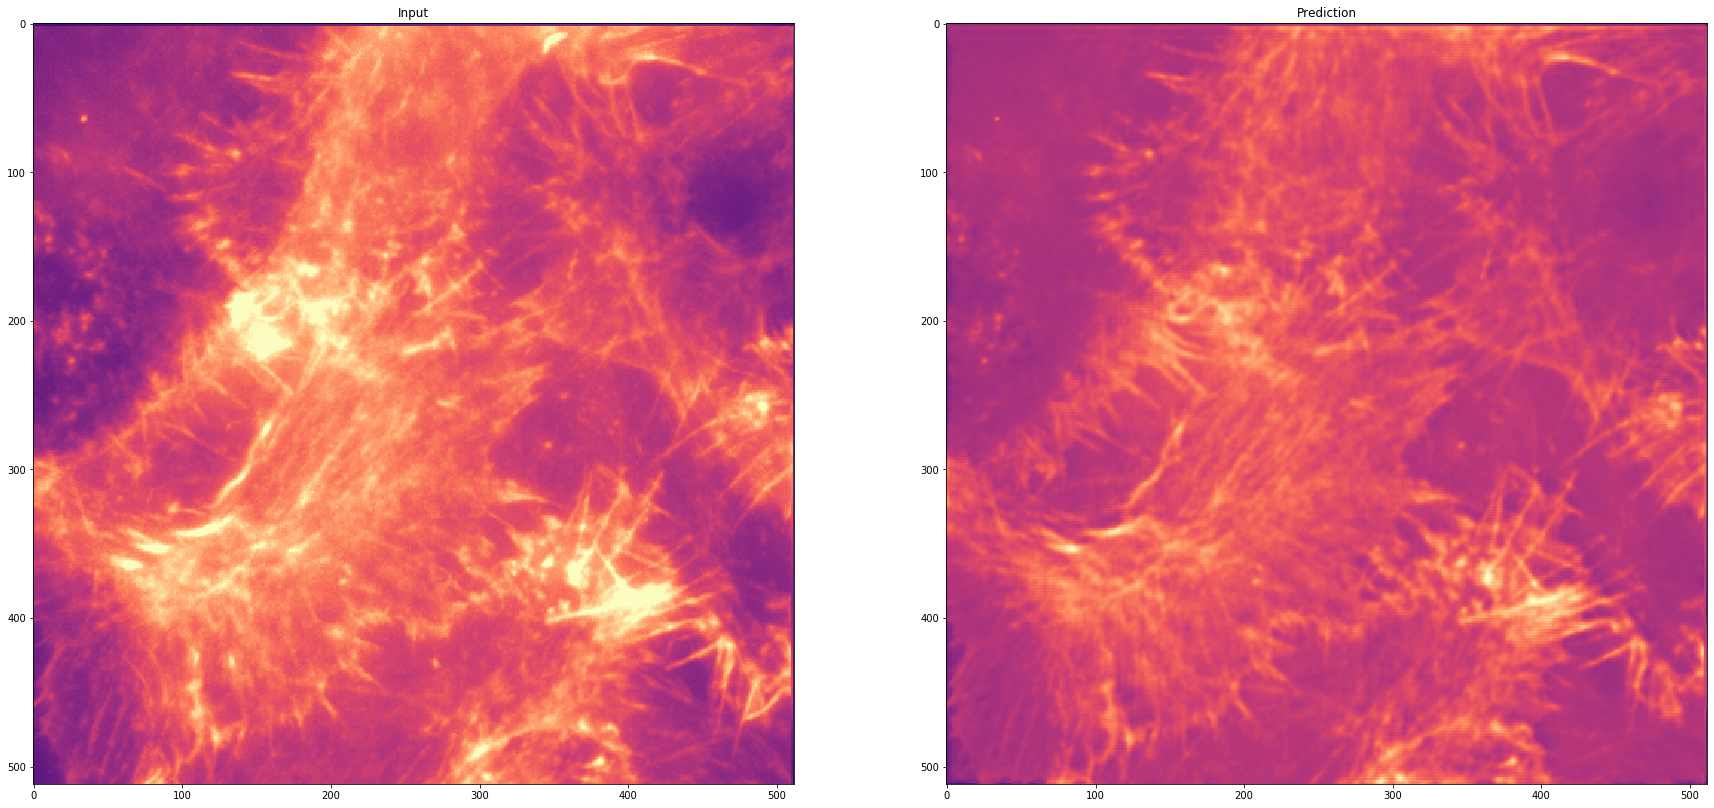

In [0]:
#@title Apply the network to the image used for the training
# We load the data we want to process.
img = imgs[0][0,...,0]

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

# Let's look at the results.
plt.figure(figsize=(30,30))

# We show the noisy input...
plt.subplot(1,2,1)
plt.imshow(np.max(img,axis=0),
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Input');

# and the result.
plt.subplot(1,2,2)
plt.imshow(np.max(pred,axis=0), 
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Prediction');

Here we estimate our training. 

**Loss error** <code>(loss)</code> descripes the error in each epoch when network process the training images.

**Validation error** <code>(val_loss)</code> descripes the error in each epoch when network process the validations images.

Both error values in the beginning of training are remarkebly higher and decrease during the training. Rule of thump is that validation loss error <code>(val_loss)</code> is slightly higher than training error <code>(loss)</code> in the latest epochs. 

If **validation error is clearly higher than training error**, it means that training data is too complicated or unrelevant and the network fails validation significally. For example like in situation where students study animal species but exam requires only knowledge of plant species. Trained network fails to improve unseen images.

If **validation error is clearly smaller than training error**, it means that training data is too simple and the network pass validation too easily. For example like in situation where student study dogs breeds but exam requires knowledge of all domesticated species. Networks fails to improve unseen images.

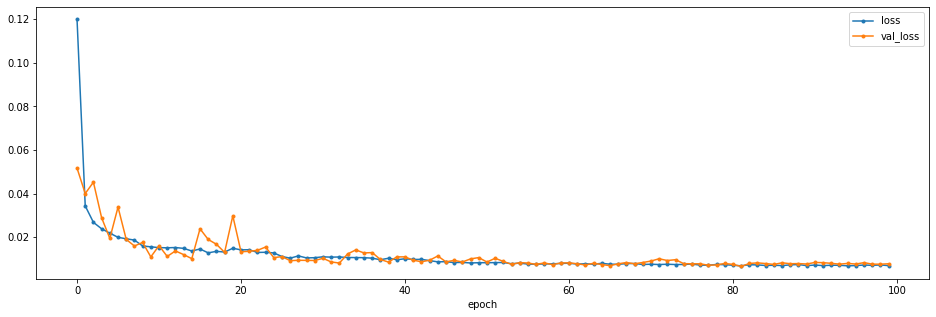

In [0]:
#@markdown Play the cell show figure of training errors.

# create a plot.
# The code is from the original notebook (https://github.com/juglab/n2v)
#@title Play the cell to show figure of training results
# print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as test.csv (refresh the Files if needed). 
RESULTS = results+'/test.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

### **4.6 Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows (optional)**
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [0]:
#@markdown Play the cell to export the model.

# The code is from the original notebook (https://github.com/juglab/n2v)
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp6cdwdg5y/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/results/N2V3D-001/TF_SavedModel.zip


# **5. Prediction of images**

This part allow to batch process images using the model (generated or pretrained).

### **5.1 Activate the trained model**

The trained model (from section 4.6) is activated and it contains all information from the training (section 4.). 

In [0]:
#@markdown Play the cell to activate pretrained model.

#@markdown If you have trained network in section 4, DO NOT run this cell.

config = None
# Let's look at the parameters stored in the config-object.
#vars(config)

# a name used to identify the model
model_name = my_model

# the base directory in which our model will live
basedir = path_model
#basedir = 'gdrive/My Drive/NOIse2VOID/Martina_Rush/3d/models'

# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)
print("Parameters transferred into the model.")

Loading network weights from 'weights_best.h5'.
Parameters transferred into the model.


### **5.2 Predict the unseen data and save the results**

Finally, the unseen data is predicted. Images are saved your results folder as restored image stacks ( ImageJ-compatible TIFF images).

In [0]:
#@markdown Play the cell to save your denoised images into results folder.
from pathlib import Path
import os
from tifffile import imread

print("Denoising images...")

thisdir = Path(test_data)
outputdir = Path(results)
suffix = '.tif'

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

# The code by Lucas von Chamier
for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='ZYX', n_tiles=(2,4,4))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename + suffix), pred_train, axes='ZYX')         
print("Prediction of images done.")

Denoising images...
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction/1070319_SI60x_actin_01_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction/1070319_SI60x_actin_02_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction/1070319_SI60x_actin_03_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction/1070319_SI60x_actin_04_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/prediction/1070319_SI60x_actin_05_WF_ALX.dv - C=1.tif
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks

100%|██████████| 32/32 [00:06<00:00,  5.24it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 3034.95it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 2125.85it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 341.33it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 4228.13it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 3622.02it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 2935.13it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 1770.50it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.15it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


  0%|          | 0/32 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 2974.68it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  0%|          | 0/32 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 377.36it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 3294.82it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 415.24it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.11it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


  0%|          | 0/32 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


  0%|          | 0/32 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 3401.71it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  3%|▎         | 1/32 [00:00<00:00, 1940.01it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  0%|          | 0/32 [00:00<?, ?it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:06<00:00,  5.12it/s]


Prediction of images done.


# **6. Store your results**

---
**Copy your data** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained_model etc) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.